In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import numpy  as np
from sklearn.decomposition import PCA
import optuna
import time
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, IsolationForest
import lightgbm as lgb
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.neighbors import KernelDensity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor  # Change here
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Data Preprocessing

In [6]:
df = pd.read_excel("MLProject_Data.xlsx", sheet_name="HDT-1")

# Convert 'Date' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the hours
df['Hour'] = df['Timestamp'].dt.hour
df['Date'] = df['Timestamp'].dt.date
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Date01'] = pd.to_datetime(df[['Month', 'Year']].assign(DAY=1))

# Filter the dataframe for the specified times
# df = df[df['Hour'].isin([7, 15, 23])]

# Calculate the number of days since January 1, 2015
reference_date = datetime(2015, 1, 1)
df['Catalyst_Age'] = (df['Timestamp'] - reference_date).dt.days

# Select features and target
features = df[['Feed_1', 'Feed_2', 'Feed_3', 'Feed_4', 'Feed_5', 'Feed_6', 'Sulfur_Product','Inlet_Temp', 'Catalyst_Age']]
target = df["H2_Consumption"]

In [3]:
df.shape

(7608, 23)

(array([19478., 19509., 19539., 19570., 19601., 19631., 19662., 19692.,
        19723., 19754., 19783.]),
 [Text(19478.0, 0, '2023-05-01'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19539.0, 0, '2023-07-01'),
  Text(19570.0, 0, '2023-08-01'),
  Text(19601.0, 0, '2023-09-01'),
  Text(19631.0, 0, '2023-10-01'),
  Text(19662.0, 0, '2023-11-01'),
  Text(19692.0, 0, '2023-12-01'),
  Text(19723.0, 0, '2024-01-01'),
  Text(19754.0, 0, '2024-02-01'),
  Text(19783.0, 0, '2024-03-01')])

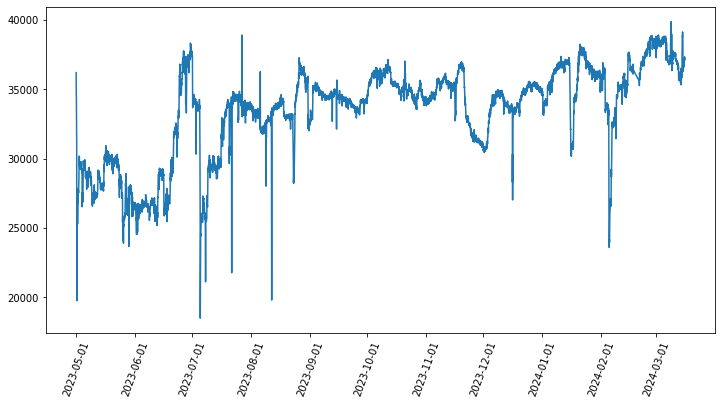

In [4]:
# plt.plot(df[df.Hour==7]['Timestamp'],df[df.Hour==7]['H2_Consumption'])
# plt.plot(df[df.Hour==15]['Timestamp'],df[df.Hour==15]['H2_Consumption'])
# plt.plot(df[df.Hour==23]['Timestamp'],df[df.Hour==23]['H2_Consumption'])
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'],df['H2_Consumption'])
plt.xticks(df['Date01'].unique())
plt.xticks(rotation=70)

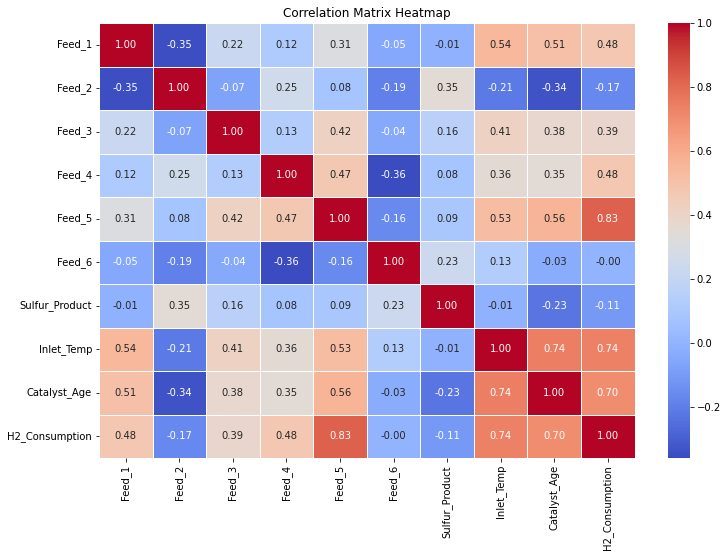

In [110]:
# Select features and target
features = df[['Feed_1', 'Feed_2', 'Feed_3', 'Feed_4', 'Feed_5', 'Feed_6', 'Sulfur_Product', 'Inlet_Temp', 'Catalyst_Age']]
target = df["H2_Consumption"]

# Combine features and target into one DataFrame
data = features.copy()
data['H2_Consumption'] = target

# Calculate the correlation matrix
corr_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Outlier detection

In [8]:
standard_scaler = StandardScaler()
features_scaled = standard_scaler.fit_transform(features)

minmax_scaler = MinMaxScaler()
features_scaled_minmax = minmax_scaler.fit_transform(features)

contamination = 0.03

In [9]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)  # You can adjust the number of components as needed
features_pca = pca.fit_transform(features_scaled)

In [10]:
def plot_outlier(method,feats,y_pred):
  x_min, x_max = feats[:, 0].min() - 1, feats[:, 0].max() + 1
  y_min, y_max = feats[:, 1].min() - 1, feats[:, 1].max() + 1
  Xp, Yp = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  Zp = method.predict(pca.inverse_transform(np.c_[Xp.ravel(), Yp.ravel()]))
  Zp = Zp.reshape(Xp.shape)

  normals = features_pca[y_pred == 1,:]
  anomals = features_pca[y_pred == -1,:]

  # Get the anomalous data points
  cntr = plt.contourf(Xp, Yp, Zp, levels=10, cmap='viridis')
  plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
  plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies')
  plt.title('Anomaly Detection using Elliptic Envelope')
  plt.colorbar(cntr)
  plt.legend()
  plt.grid()
  plt.show()

### KDE

In [11]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)  # You can adjust the number of components as needed
features_pca = pca.fit_transform(features_scaled)

kde = KernelDensity(kernel='gaussian').fit(features_scaled)
scores_kde = kde.score_samples(features_scaled)
threshold = np.quantile(scores_kde,contamination)
normals = features_pca[scores_kde > threshold,:]
anomals = features_pca[scores_kde <= threshold,:]

features_outlier_removed_kde = features_scaled_minmax[scores_kde > threshold,:]
target_outliers_removed_kde = target[scores_kde > threshold]

In [12]:
features_outlier_removed =  pd.DataFrame(data = features_outlier_removed_kde, columns=features.columns)
features_scaled_df = pd.DataFrame(data = features_scaled, columns=features.columns)

## Feature Selection

# Feats:  1
# Feats:  2
# Feats:  3
# Feats:  4
# Feats:  5
# Feats:  6
# Feats:  7
# Feats:  8
# Feats:  9


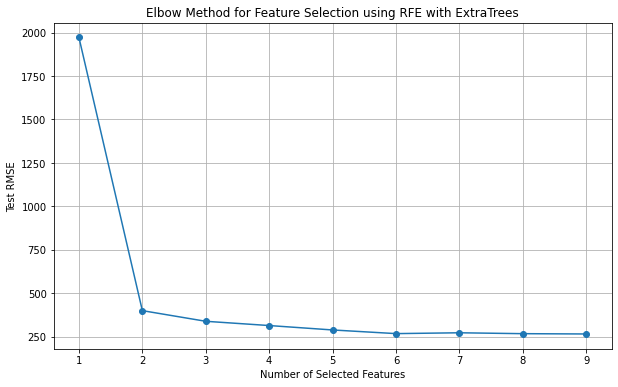

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_outlier_removed, target_outliers_removed_kde, test_size=0.3, random_state=0)

# Initialize the ExtraTreesRegressor
# estimator = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here
estimator = RandomForestRegressor(n_estimators=100, random_state=0)  # Change here

# Store RMSE values for different numbers of selected features
rmse_values = []
best_features = []

# Perform RFE with different numbers of features selected (from 1 to 9)
for n_features in range(1, 10):
    print("# Feats: ",n_features)
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train, y_train)
    selected_features = features.columns[selector.support_]

    # Select features based on RFE results
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Standardize the features
    # scaler = MinMaxScaler()
    # X_train_scaled = scaler.fit_transform(X_train_selected)
    # X_test_scaled = scaler.transform(X_test_selected)

    # Train the ExtraTreesRegressor model
    rf_reg = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here
    rf_reg.fit(X_train_selected, y_train)

    # Evaluate the model
    score = mean_squared_error(y_test, rf_reg.predict(X_test_selected), squared=False)
    # test_rmse = mean_squared_error(y_test, et_reg.predict(X_test_scaled), squared=False)

    rmse_values.append(score)

    best_features.append(selected_features)

# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), rmse_values, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Test RMSE')
plt.title('Elbow Method for Feature Selection using RFE with ExtraTrees')
plt.grid()
plt.show()

In [32]:
feature_selection_rf = rmse_values
best_features_rf = best_features

# Feats:  1
# Feats:  2
# Feats:  3
# Feats:  4
# Feats:  5
# Feats:  6
# Feats:  7
# Feats:  8
# Feats:  9


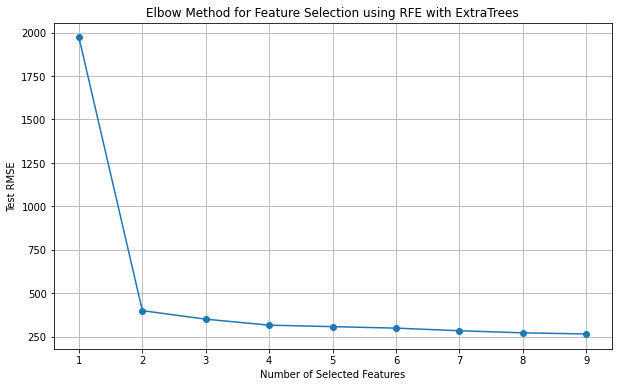

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_outlier_removed, target_outliers_removed_kde, test_size=0.3, random_state=0)

# Initialize the ExtraTreesRegressor
estimator = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here


# Store RMSE values for different numbers of selected features
rmse_values = []
best_features = []

# Perform RFE with different numbers of features selected (from 1 to 9)
for n_features in range(1, 10):
    print("# Feats: ",n_features)
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train, y_train)
    selected_features = features.columns[selector.support_]

    # Select features based on RFE results
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Standardize the features
    # scaler = MinMaxScaler()
    # X_train_scaled = scaler.fit_transform(X_train_selected)
    # X_test_scaled = scaler.transform(X_test_selected)

    # Train the ExtraTreesRegressor model
    et_reg = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here
    et_reg.fit(X_train_selected, y_train)

    # Evaluate the model
    score = mean_squared_error(y_test, et_reg.predict(X_test_selected), squared=False)

    score = score.mean()
    # test_rmse = mean_squared_error(y_test, et_reg.predict(X_test_scaled), squared=False)
    rmse_values.append(score)

    best_features.append(selected_features)

# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), rmse_values, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Test RMSE')
plt.title('Elbow Method for Feature Selection using RFE with ExtraTrees')
plt.grid()
plt.show()

In [45]:
feature_selection_et = rmse_values
best_features_et = best_features

In [46]:
feature_selection_scores = pd.DataFrame({"Number of Features": range(1,10),
                                         "Extra Trees RMSE": feature_selection_et, 
                                         "Extra Trees Best Features": best_features_et,
                                         "Random Forest RMSE":feature_selection_rf,
                                         "Random Forest Best Features": best_features_rf
})
feature_selection_scores

,Number of Features,Extra Trees RMSE,Extra Trees Best Features,Random Forest RMSE,Random Forest Best Features
0,1,1971.876305,"Index(['Feed_5'], dtype='object')",1971.876305,"Index(['Feed_5'], dtype='object')"
1,2,400.528379,"Index(['Feed_5', 'Catalyst_Age'], dtype='object')",400.528379,"Index(['Feed_5', 'Catalyst_Age'], dtype='object')"
2,3,351.351985,"Index(['Feed_5', 'Inlet_Temp', 'Catalyst_Age']...",339.256120,"Index(['Feed_1', 'Feed_5', 'Catalyst_Age'], dt..."
3,4,317.070046,"Index(['Feed_1', 'Feed_5', 'Inlet_Temp', 'Cata...",314.780806,"Index(['Feed_1', 'Feed_5', 'Sulfur_Product', '..."
4,5,308.517206,"Index(['Feed_1', 'Feed_5', 'Sulfur_Product', '...",289.374553,"Index(['Feed_1', 'Feed_5', 'Feed_6', 'Sulfur_P..."
5,6,299.962986,"Index(['Feed_1', 'Feed_2', 'Feed_5', 'Sulfur_P...",268.346378,"Index(['Feed_1', 'Feed_4', 'Feed_5', 'Feed_6',..."
6,7,284.914565,"Index(['Feed_1', 'Feed_2', 'Feed_4', 'Feed_5',...",273.179988,"Index(['Feed_1', 'Feed_4', 'Feed_5', 'Feed_6',..."
7,8,272.844074,"Index(['Feed_1', 'Feed_2', 'Feed_4', 'Feed_5',...",268.016819,"Index(['Feed_1', 'Feed_3', 'Feed_4', 'Feed_5',..."
8,9,266.284778,"Index(['Feed_1', 'Feed_2', 'Feed_3', 'Feed_4',...",266.284778,"Index(['Feed_1', 'Feed_2', 'Feed_3', 'Feed_4',..."


In [47]:
feature_selection_scores.to_csv('output\\Features_selection.csv',index=False)

In [111]:
outlier_removed = True
number_of_feat=2

if outlier_removed:
# With outliers removed
  features_selected_scaled = features_outlier_removed[best_features[number_of_feat-1].tolist()]
  X_train, X_test, y_train, y_test = train_test_split(features_selected_scaled, target_outliers_removed_kde, test_size=0.3, random_state=0)
  
else:
# No outlier removed
  features_selected_scaled = features_scaled_df[best_features[number_of_feat-1].tolist()]
  X_train, X_test, y_train, y_test = train_test_split(features_selected_scaled, target, test_size=0.3, random_state=0)

## Baseline Score for ET and RF (no outliers removed)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features[['Feed_5', 'Catalyst_Age']], target, test_size=0.3, random_state=0)

In [51]:
rf_reg_base = RandomForestRegressor(n_estimators=100, random_state=0)  # Change here

cv_scores = cross_val_score(rf_reg_base,X_train,y_train , cv=10, scoring='neg_root_mean_squared_error')
train_score  = -cv_scores.mean()
print('Random Forest Train RMSE (no outlier removed):', train_score)

rf_reg_base.fit(X_train, y_train)

# Evaluate the model
test_score = mean_squared_error(y_test, rf_reg_base.predict(X_test), squared=False)
print('Random Forest Test RMSE (no outlier removed):', test_score)

Random Forest Train RMSE (no outlier removed): 430.20592982488387
Random Forest Test RMSE (no outlier removed): 488.57881439760735


In [52]:
et_reg_base = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here
et_reg_base.fit(X_train, y_train)

cv_scores = cross_val_score(et_reg_base,X_train,y_train , cv=10, scoring='neg_root_mean_squared_error')
train_score  = -cv_scores.mean()
print('Extra Trees Train RMSE (no outlier removed):', train_score)

# Evaluate the model
test_score = mean_squared_error(y_test, et_reg_base.predict(X_test), squared=False)
print('Extra Trees Test RMSE (no outlier removed):', test_score)

Extra Trees Train RMSE (no outlier removed): 432.2174781339339
Extra Trees Test RMSE (no outlier removed): 510.8540816973039


## Baseline Score for ET and RF (outliers removed)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(features_outlier_removed[['Feed_5', 'Catalyst_Age']], target_outliers_removed_kde, test_size=0.3, random_state=0)

In [115]:
rf_reg_base_outlier_removed = RandomForestRegressor(n_estimators=100, random_state=0)  # Change here

cv_scores = cross_val_score(rf_reg_base,X_train,y_train , cv=10, scoring='neg_root_mean_squared_error')
train_score  = -cv_scores.mean()
print('Random Forest Train RMSE (outlier removed):', train_score)

rf_reg_base.fit(X_train, y_train)

# Evaluate the model
test_score = mean_squared_error(y_test, rf_reg_base.predict(X_test), squared=False)
print('Random Forest Test RMSE (outlier removed):', test_score)

Random Forest Train RMSE (outlier removed): 385.36840802989065
Random Forest Test RMSE (outlier removed): 390.8620751024026


In [116]:
et_reg_base = ExtraTreesRegressor(n_estimators=100, random_state=0)  # Change here
et_reg_base.fit(X_train, y_train)

cv_scores = cross_val_score(et_reg_base,X_train,y_train , cv=10, scoring='neg_root_mean_squared_error')
train_score  = -cv_scores.mean()
print('Extra Trees Train RMSE (outlier removed):', train_score)

# Evaluate the model
test_score = mean_squared_error(y_test, et_reg_base.predict(X_test), squared=False)
print('Extra Trees Test RMSE (outlier removed):', test_score)

Extra Trees Train RMSE (outlier removed): 395.6748925625295
Extra Trees Test RMSE (outlier removed): 400.5283785687185


## Hyperparam Tuning

### Random Forest Regressor

In [76]:
start_time = time.time()
def objective_rf(trial):
  n_estimators = trial.suggest_int("n_estimators",80, 120)
  max_depth = trial.suggest_int("max_depth",15, 25)
  min_samples_leaf = trial.suggest_int("min_samples_leaf",1,3)
  min_samples_split = trial.suggest_int("min_samples_split",2,5)
  ccp_alpha = trial.suggest_float("ccp_alpha",0,0.1)

  pipe_rf = Pipeline([
  ('rf', RandomForestRegressor(n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                            ccp_alpha=ccp_alpha
  ))])

  score = cross_val_score(pipe_rf, X_train, y_train, scoring='neg_root_mean_squared_error',cv=10)
  avg_score = -score.mean()
  
  return avg_score

sampler=TPESampler(seed=0)
study_rf = optuna.create_study(sampler=sampler, direction="minimize") # maximise the score during tuning
study_rf.optimize(objective_rf, n_trials = 100) # run the objective function 100 times
end_time = time.time()
rf_time = end_time - start_time

# Best Trial
best_trial_rf = study_rf.best_trial
print("Training Accuracy: {}".format(best_trial_rf.value))
print("Best hyperparameters: {}".format(best_trial_rf.params))
print("Training Time Random Forest: ", rf_time)

[I 2024-06-14 00:05:22,162] A new study created in memory with name: no-name-04e972da-b7dc-44b0-8a21-9cef3a172fb1
[I 2024-06-14 00:05:49,841] Trial 0 finished with value: 377.1341634352032 and parameters: {'n_estimators': 102, 'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 4, 'ccp_alpha': 0.042365479933890476}. Best is trial 0 with value: 377.1341634352032.
[I 2024-06-14 00:06:13,568] Trial 1 finished with value: 381.24065115001827 and parameters: {'n_estimators': 106, 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5, 'ccp_alpha': 0.038344151882577775}. Best is trial 0 with value: 377.1341634352032.
[I 2024-06-14 00:06:35,304] Trial 2 finished with value: 376.64861128628195 and parameters: {'n_estimators': 112, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'ccp_alpha': 0.007103605819788694}. Best is trial 2 with value: 376.64861128628195.
[I 2024-06-14 00:06:48,618] Trial 3 finished with value: 383.2580844745086 and parameters: {'n_estimato

Training Accuracy: 373.0188738719447
Best hyperparameters: {'n_estimators': 82, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'ccp_alpha': 0.05546639067851282}
Training Time Random Forest:  1808.7860655784607


In [83]:
optuna.visualization.plot_param_importances(
    study_rf, target=lambda t: t.values[0], target_name="flops"
)

In [77]:
joblib.dump(study_rf, f"rf_kde_feat_{number_of_feat}_study.pkl")

['rf_kde_feat_2_study.pkl']

In [78]:
# Fit New Model Using Best Trial
rf = RandomForestRegressor(n_estimators=best_trial_rf.params['n_estimators'],
                            max_depth=best_trial_rf.params['max_depth'], 
                            min_samples_leaf=best_trial_rf.params['min_samples_leaf'], min_samples_split=best_trial_rf.params['min_samples_split'],
                            ccp_alpha=best_trial_rf.params['ccp_alpha'])
rf.fit(X_train,y_train)
test_rmse_rf = mean_squared_error(y_test, rf.predict(X_test), squared=False)
test_rmse_rf

385.772370361327

In [79]:
rf_r2_score = r2_score(y_test, rf.predict(X_test))

In [80]:
rf_summary_scores = pd.DataFrame({'Random Forest': 
                                  {"Training Time (s)": rf_time, 
                                  "Train RMSE": best_trial_rf.value,
                                  "Test RMSE": test_rmse_rf, 
                                  "Best Hyperparameters": str(best_trial_rf.params),
                                  "Test R2": rf_r2_score,
}})
rf_summary_scores

,Random Forest
Best Hyperparameters,"{'n_estimators': 82, 'max_depth': 15, 'min_sam..."
Test R2,0.985852
Test RMSE,385.77237
Train RMSE,373.018874
Training Time (s),1808.786066


In [81]:
rf_summary_scores.to_csv('output\\randomforest_summary_scores.csv')

### ExtraTrees Regressor

In [99]:
start_time = time.time()
def objective_et(trial):
  n_estimators = trial.suggest_int("n_estimators",80, 120)
  max_depth = trial.suggest_int("max_depth",15, 25)
  min_samples_leaf = trial.suggest_int("min_samples_leaf",1,3)
  min_samples_split = trial.suggest_int("min_samples_split",2,5)
  ccp_alpha = trial.suggest_float("ccp_alpha",0,0.1)

  pipe_et = Pipeline([
  ('rf', ExtraTreesRegressor(n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                            ccp_alpha=ccp_alpha
  ))])

  score = cross_val_score(pipe_et, X_train, y_train, scoring='neg_root_mean_squared_error',cv=10)
  avg_score = -score.mean()
  
  return avg_score

sampler=TPESampler(seed=0)
study_et = optuna.create_study(sampler=sampler, direction="minimize") # maximise the score during tuning
study_et.optimize(objective_et, n_trials = 100) # run the objective function 100 times
end_time = time.time()
et_time = end_time - start_time

# Best Trial
best_trial_et = study_et.best_trial
print("Training Accuracy: {}".format(best_trial_et.value))
print("Best hyperparameters: {}".format(best_trial_et.params))
print("Training Time Extra Trees: ", et_time)

[I 2024-06-14 01:11:39,313] A new study created in memory with name: no-name-f83bdc96-acc9-4ae6-bd80-da01271e15ac
[I 2024-06-14 01:11:44,820] Trial 0 finished with value: 352.62920954729145 and parameters: {'n_estimators': 102, 'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 4, 'ccp_alpha': 0.042365479933890476}. Best is trial 0 with value: 352.62920954729145.
[I 2024-06-14 01:11:49,716] Trial 1 finished with value: 364.02967456370374 and parameters: {'n_estimators': 106, 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5, 'ccp_alpha': 0.038344151882577775}. Best is trial 0 with value: 352.62920954729145.
[I 2024-06-14 01:11:55,567] Trial 2 finished with value: 349.38692188295937 and parameters: {'n_estimators': 112, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'ccp_alpha': 0.007103605819788694}. Best is trial 2 with value: 349.38692188295937.
[I 2024-06-14 01:11:58,659] Trial 3 finished with value: 368.69734655724034 and parameters: {'n_esti

Training Accuracy: 349.38692188295937
Best hyperparameters: {'n_estimators': 112, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'ccp_alpha': 0.007103605819788694}
Training Time Extra Trees:  525.55708527565


In [108]:
optuna.visualization.plot_param_importances(
    study_et, target=lambda t: t.values[0], target_name="flops"
)

In [101]:
# Fit New Model Using Best Trial
et = ExtraTreesRegressor(n_estimators=best_trial_et.params['n_estimators'],
                            max_depth=best_trial_et.params['max_depth'], 
                            min_samples_leaf=best_trial_et.params['min_samples_leaf'], 
                            min_samples_split=best_trial_et.params['min_samples_split'],
                            ccp_alpha=best_trial_et.params['ccp_alpha'])
et.fit(X_train,y_train)
test_rmse_et = mean_squared_error(y_test, et.predict(X_test), squared=False)
print("Testing Accuracy: {}".format(test_rmse_et))

Testing Accuracy: 353.21811012669235


In [102]:
joblib.dump(et,'extratrees_best_model.pkl')
joblib.dump(X_test,'extratrees_X_test.pkl')
joblib.dump(X_train,'extratrees_X_train.pkl')

['extratrees_X_train.pkl']

In [103]:
X_test.to_csv('extratrees_X_test.csv',index=False)
X_train.to_csv('extratrees_X_train.csv',index=False)

In [104]:
joblib.dump(study_et, f"extratrees_kde_feat_{number_of_feat}_minmax_study.pkl") 

# to load it:
# jl = joblib.load(f"extrarees_iso_feat_5_study.pkl")

['extratrees_kde_feat_2_minmax_study.pkl']

In [105]:
et_r2_score = r2_score(y_test, et.predict(X_test))
et_r2_score

0.9881390097860147

In [106]:
et_summary_scores = pd.DataFrame({'Extra Trees': 
                                  {"Training Time (s)": et_time, 
                                  "Train RMSE": best_trial_et.value,
                                  "Test RMSE": test_rmse_et, 
                                  "Best Hyperparameters": str(best_trial_et.params),
                                  "Test R2": et_r2_score,
}})
et_summary_scores

,Extra Trees
Best Hyperparameters,"{'n_estimators': 112, 'max_depth': 20, 'min_sa..."
Test R2,0.988139
Test RMSE,353.21811
Train RMSE,349.386922
Training Time (s),525.557085


In [107]:
et_summary_scores.to_csv('output\\extratrees_smmaruy_scores.csv')

In [177]:
lr = LinearRegression()

In [178]:
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Linear Regression RMSE:", (-scores.mean()))

Linear Regression RMSE: 1398.1092603219433
